In [ ]:
# =========================
# 1. IMPORTS
# =========================
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

plt.style.use("seaborn-v0_8")


In [ ]:
# =========================
# 2. DATA LOADING (KAGGLEHUB)
# =========================
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

files = []
for root, _, filenames in os.walk(path):
    for f in filenames:
        if f.endswith(".csv"):
            files.append(os.path.join(root, f))

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# Standardize column names
df.columns = df.columns.str.strip().str.replace(" ", "")
df.rename(columns={"Invoice": "InvoiceNo", "Price": "UnitPrice"}, inplace=True)

print("Initial shape:", df.shape)

Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.
Initial shape: (1067371, 8)


In [ ]:
# 3. DATA CLEANING
# =========================
# Drop rows without CustomerID (mandatory for CLV)
df = df.dropna(subset=["CustomerID"])

# Datetime conversion
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

# Remove cancelled invoices
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Keep only valid transactions
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Transaction value
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

print("After cleaning:", df.shape)


After cleaning: (805549, 9)


In [ ]:
# =========================
# 3.5. EDA - BASIC STATISTICS
# =========================
print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"\nColumn Data Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nBasic Statistics:\n{df.describe()}")

print("\n" + "=" * 60)
print("UNIQUE VALUES")
print("=" * 60)
print(f"Unique Customers: {df['CustomerID'].nunique()}")
print(f"Unique Invoices: {df['InvoiceNo'].nunique()}")
print(f"Unique Products: {df['StockCode'].nunique()}")
print(f"Unique Countries: {df['Country'].nunique()}")

print("\n" + "=" * 60)
print("TRANSACTION STATISTICS")
print("=" * 60)
print(f"Date Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"Average Quantity per Transaction: {df['Quantity'].mean():.2f}")
print(f"Average Unit Price: ${df['UnitPrice'].mean():.2f}")
print(f"Average Transaction Value: ${df['TotalPrice'].mean():.2f}")
print(f"Total Revenue: ${df['TotalPrice'].sum():,.2f}")


DATA OVERVIEW

Dataset Shape: (805549, 9)

Column Data Types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalPrice            float64
dtype: object

Missing Values:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

Basic Statistics:
            Quantity                    InvoiceDate      UnitPrice  \
count  805549.000000                         805549  805549.000000   
mean       13.290522  2011-01-02 10:24:44.106814464       3.206561   
min         1.000000            2009-12-01 07:45:00       0.001000   
25%         2.000000            2010-07-07 12:08:00       1.250000   
50%         5.000000            2010-12-03 15:10:00       1.950000   
75%        12.000000            

In [ ]:
# =========================
# 4. DATE DEFINITIONS (STRICT)
# =========================
TRAIN_END_DATE = datetime(2011, 10, 1)
TEST_START_DATE = datetime(2011, 10, 1)
TEST_END_DATE = datetime(2011, 10, 31)

train_txn = df[df["InvoiceDate"] < TRAIN_END_DATE]
test_txn  = df[(df["InvoiceDate"] >= TEST_START_DATE) &
               (df["InvoiceDate"] <= TEST_END_DATE)]

In [ ]:
# =========================
# 5. TARGET (TEST WINDOW SPEND)
# =========================
future_spend = (
    test_txn.groupby("CustomerID")["TotalPrice"]
    .sum()
    .reset_index(name="target_30d_spend")
)

OUTLIER DETECTION:
Quantity - Max: 74215, Min: 1
Quantity - 99th percentile: 144.0
Quantity - 95th percentile: 40.0
Number of extremely high quantity transactions (>10000): 6

UnitPrice - Max: $10953.5, Min: $0.001
UnitPrice - 99th percentile: $14.95

TotalPrice - Max: $77183.6, Min: $0.001
TotalPrice - 99th percentile: $204.0


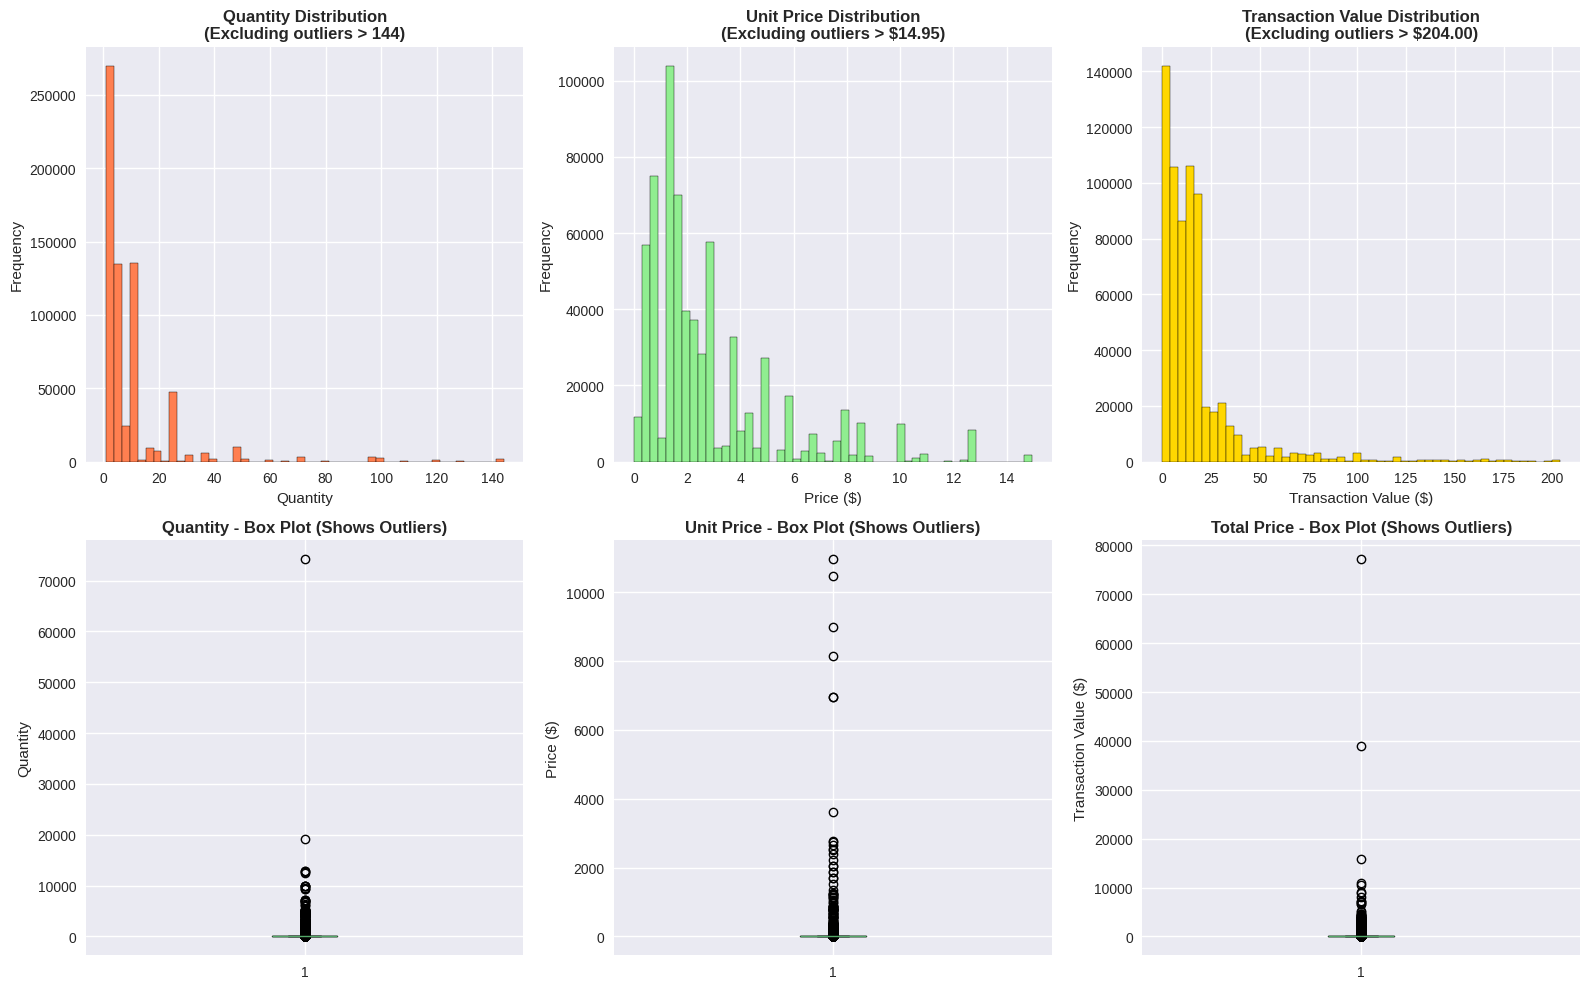


OUTLIER INSIGHT:
The extreme outliers are pulling the scale of the histogram, making the normal data invisible.
For modeling, you may want to cap these values or use log transformation.


In [ ]:
# =========================
# 4.7. EDA - OUTLIER ANALYSIS & CORRECTED DISTRIBUTIONS
# =========================
print("OUTLIER DETECTION:")
print(f"Quantity - Max: {train_txn['Quantity'].max()}, Min: {train_txn['Quantity'].min()}")
print(f"Quantity - 99th percentile: {train_txn['Quantity'].quantile(0.99)}")
print(f"Quantity - 95th percentile: {train_txn['Quantity'].quantile(0.95)}")
print(f"Number of extremely high quantity transactions (>10000): {(train_txn['Quantity'] > 10000).sum()}")

print(f"\nUnitPrice - Max: ${train_txn['UnitPrice'].max()}, Min: ${train_txn['UnitPrice'].min()}")
print(f"UnitPrice - 99th percentile: ${train_txn['UnitPrice'].quantile(0.99)}")

print(f"\nTotalPrice - Max: ${train_txn['TotalPrice'].max()}, Min: ${train_txn['TotalPrice'].min()}")
print(f"TotalPrice - 99th percentile: ${train_txn['TotalPrice'].quantile(0.99)}")

# Create better visualizations with outliers handled
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Quantity - with outliers removed (using 99th percentile)
q99_qty = train_txn['Quantity'].quantile(0.99)
axes[0, 0].hist(train_txn[train_txn['Quantity'] <= q99_qty]['Quantity'], bins=50, color="coral", edgecolor="black")
axes[0, 0].set_title(f"Quantity Distribution\n(Excluding outliers > {q99_qty:.0f})", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Quantity")
axes[0, 0].set_ylabel("Frequency")

# Unit Price - with outliers removed
q99_price = train_txn['UnitPrice'].quantile(0.99)
axes[0, 1].hist(train_txn[train_txn['UnitPrice'] <= q99_price]['UnitPrice'], bins=50, color="lightgreen", edgecolor="black")
axes[0, 1].set_title(f"Unit Price Distribution\n(Excluding outliers > ${q99_price:.2f})", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Price ($)")
axes[0, 1].set_ylabel("Frequency")

# Total Price - with outliers removed
q99_total = train_txn['TotalPrice'].quantile(0.99)
axes[0, 2].hist(train_txn[train_txn['TotalPrice'] <= q99_total]['TotalPrice'], bins=50, color="gold", edgecolor="black")
axes[0, 2].set_title(f"Transaction Value Distribution\n(Excluding outliers > ${q99_total:.2f})", fontsize=12, fontweight="bold")
axes[0, 2].set_xlabel("Transaction Value ($)")
axes[0, 2].set_ylabel("Frequency")

# Box plots to show outliers
axes[1, 0].boxplot(train_txn['Quantity'], vert=True)
axes[1, 0].set_title("Quantity - Box Plot (Shows Outliers)", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Quantity")

axes[1, 1].boxplot(train_txn['UnitPrice'], vert=True)
axes[1, 1].set_title("Unit Price - Box Plot (Shows Outliers)", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Price ($)")

axes[1, 2].boxplot(train_txn['TotalPrice'], vert=True)
axes[1, 2].set_title("Total Price - Box Plot (Shows Outliers)", fontsize=12, fontweight="bold")
axes[1, 2].set_ylabel("Transaction Value ($)")

plt.tight_layout()
plt.show()

print("\nOUTLIER INSIGHT:")
print("The extreme outliers are pulling the scale of the histogram, making the normal data invisible.")
print("For modeling, you may want to cap these values or use log transformation.")


In [ ]:
# =========================
# 6. FEATURE ENGINEERING (TRAIN ONLY)
# =========================
features = train_txn.groupby("CustomerID").agg(
    recency=("InvoiceDate", lambda x: (TRAIN_END_DATE - x.max()).days),
    frequency=("InvoiceNo", "nunique"),
    total_quantity=("Quantity", "sum"),
    total_spend=("TotalPrice", "sum"),
    avg_order_value=("TotalPrice", "mean"),
    unique_products=("StockCode", "nunique"),
    country=("Country", "first")
).reset_index()

data = features.merge(future_spend, on="CustomerID", how="left")
data["target_30d_spend"] = data["target_30d_spend"].fillna(0)

In [ ]:
# =========================
# 7. BASELINE (NAIVE MEAN)
# =========================
baseline_pred = np.full(len(data), data["target_30d_spend"].mean())
print("Baseline MAE:",
      mean_absolute_error(data["target_30d_spend"], baseline_pred))

Baseline MAE: 266.22978784819776


In [ ]:
# =========================
# 8. FINAL DATASET
# =========================
X = data.drop(columns=["CustomerID", "target_30d_spend"])
y = data["target_30d_spend"]

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = ["country"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

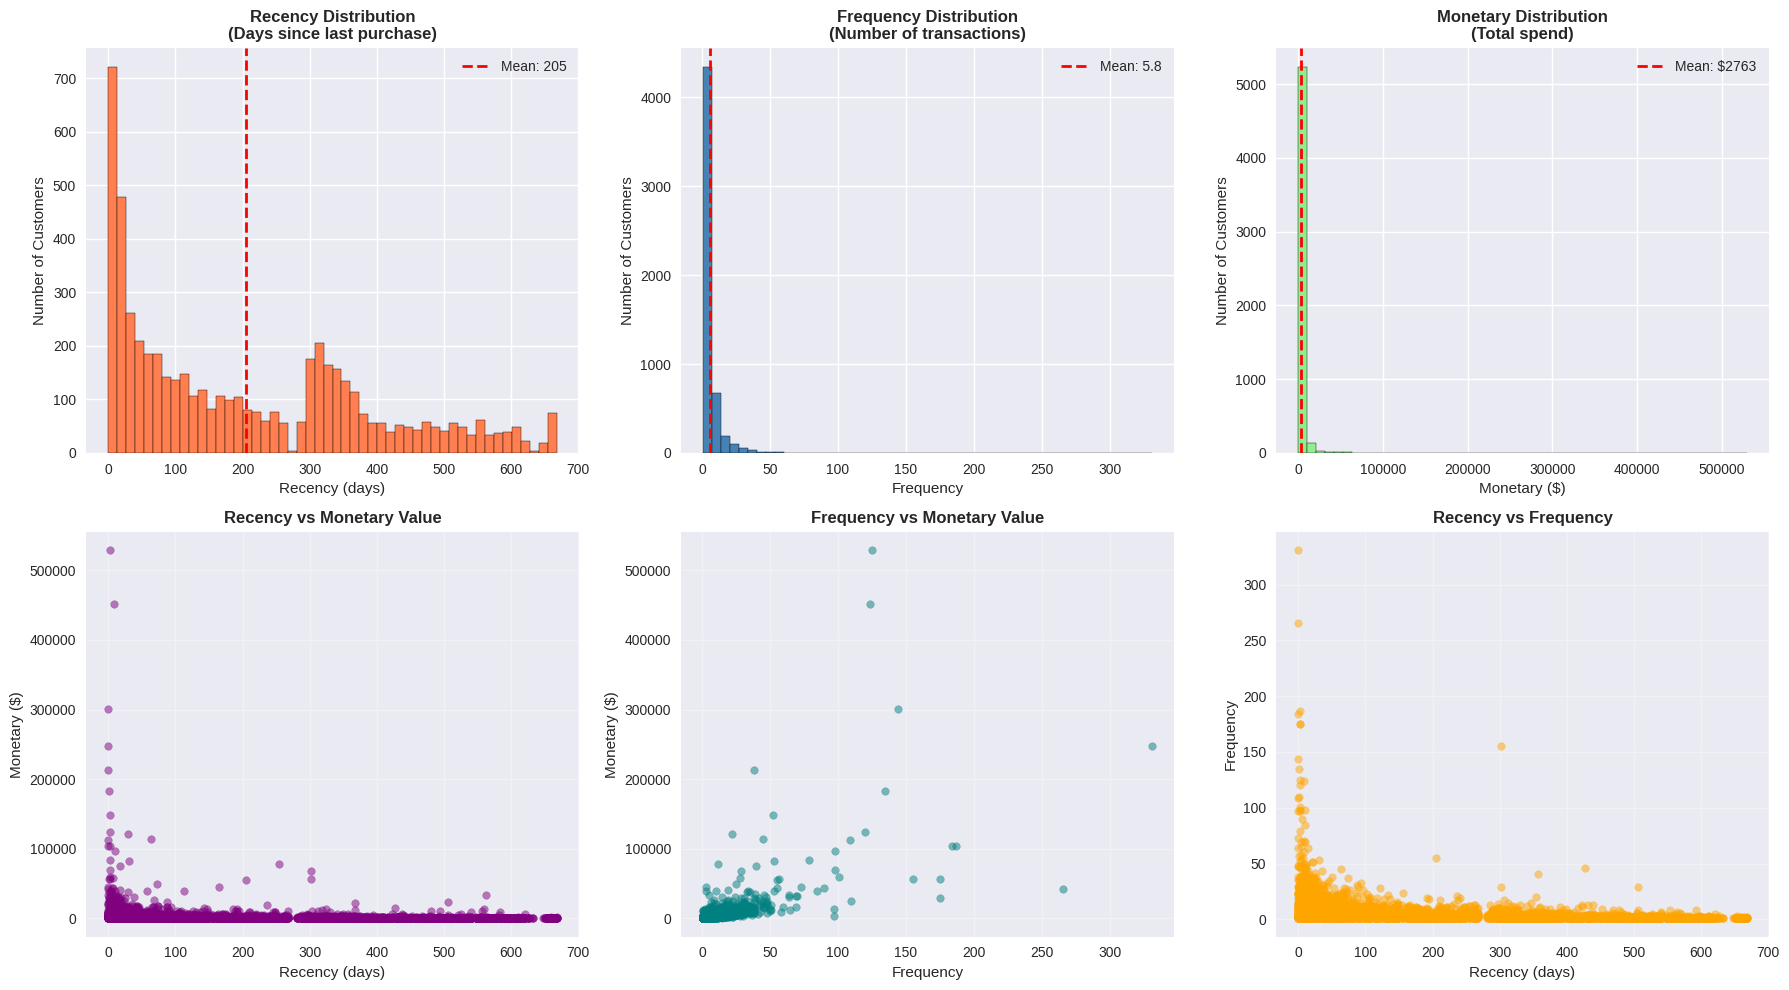

RFM STATISTICS:

Recency (days since last purchase):
  Mean: 204.69, Median: 148.00
  Min: 0, Max: 668

Frequency (number of transactions):
  Mean: 5.81, Median: 3.00
  Min: 1, Max: 331

Monetary (total spend):
  Mean: $2762.80, Median: $810.98
  Min: $2.90, Max: $529323.76


In [ ]:
# =========================
# 6.5. EDA - RFM ANALYSIS
# =========================
# Create RFM features for visualization
rfm_data = train_txn.groupby("CustomerID").agg(
    recency=("InvoiceDate", lambda x: (TRAIN_END_DATE - x.max()).days),
    frequency=("InvoiceNo", "nunique"),
    monetary=("TotalPrice", "sum")
).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Recency distribution
axes[0, 0].hist(rfm_data["recency"], bins=50, color="coral", edgecolor="black")
axes[0, 0].set_title("Recency Distribution\n(Days since last purchase)", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Recency (days)")
axes[0, 0].set_ylabel("Number of Customers")
axes[0, 0].axvline(rfm_data["recency"].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {rfm_data['recency'].mean():.0f}")
axes[0, 0].legend()

# Frequency distribution
axes[0, 1].hist(rfm_data["frequency"], bins=50, color="steelblue", edgecolor="black")
axes[0, 1].set_title("Frequency Distribution\n(Number of transactions)", fontsize=12, fontweight="bold")
axes[0, 1].set_xlabel("Frequency")
axes[0, 1].set_ylabel("Number of Customers")
axes[0, 1].axvline(rfm_data["frequency"].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {rfm_data['frequency'].mean():.1f}")
axes[0, 1].legend()

# Monetary distribution
axes[0, 2].hist(rfm_data["monetary"], bins=50, color="lightgreen", edgecolor="black")
axes[0, 2].set_title("Monetary Distribution\n(Total spend)", fontsize=12, fontweight="bold")
axes[0, 2].set_xlabel("Monetary ($)")
axes[0, 2].set_ylabel("Number of Customers")
axes[0, 2].axvline(rfm_data["monetary"].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: ${rfm_data['monetary'].mean():.0f}")
axes[0, 2].legend()

# Recency vs Monetary
axes[1, 0].scatter(rfm_data["recency"], rfm_data["monetary"], alpha=0.5, s=30, color="purple")
axes[1, 0].set_title("Recency vs Monetary Value", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Recency (days)")
axes[1, 0].set_ylabel("Monetary ($)")
axes[1, 0].grid(True, alpha=0.3)

# Frequency vs Monetary
axes[1, 1].scatter(rfm_data["frequency"], rfm_data["monetary"], alpha=0.5, s=30, color="teal")
axes[1, 1].set_title("Frequency vs Monetary Value", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Frequency")
axes[1, 1].set_ylabel("Monetary ($)")
axes[1, 1].grid(True, alpha=0.3)

# Recency vs Frequency
axes[1, 2].scatter(rfm_data["recency"], rfm_data["frequency"], alpha=0.5, s=30, color="orange")
axes[1, 2].set_title("Recency vs Frequency", fontsize=12, fontweight="bold")
axes[1, 2].set_xlabel("Recency (days)")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("RFM STATISTICS:")
print(f"\nRecency (days since last purchase):")
print(f"  Mean: {rfm_data['recency'].mean():.2f}, Median: {rfm_data['recency'].median():.2f}")
print(f"  Min: {rfm_data['recency'].min()}, Max: {rfm_data['recency'].max()}")

print(f"\nFrequency (number of transactions):")
print(f"  Mean: {rfm_data['frequency'].mean():.2f}, Median: {rfm_data['frequency'].median():.2f}")
print(f"  Min: {rfm_data['frequency'].min()}, Max: {rfm_data['frequency'].max()}")

print(f"\nMonetary (total spend):")
print(f"  Mean: ${rfm_data['monetary'].mean():.2f}, Median: ${rfm_data['monetary'].median():.2f}")
print(f"  Min: ${rfm_data['monetary'].min():.2f}, Max: ${rfm_data['monetary'].max():.2f}")


RFM FEATURES CORRELATION ANALYSIS

RFM CORRELATION MATRIX:
                   recency  frequency  monetary  target_30d_spend
recency           1.000000  -0.283923 -0.140750         -0.105962
frequency        -0.283923   1.000000  0.635707          0.425045
monetary         -0.140750   0.635707  1.000000          0.807949
target_30d_spend -0.105962   0.425045  0.807949          1.000000


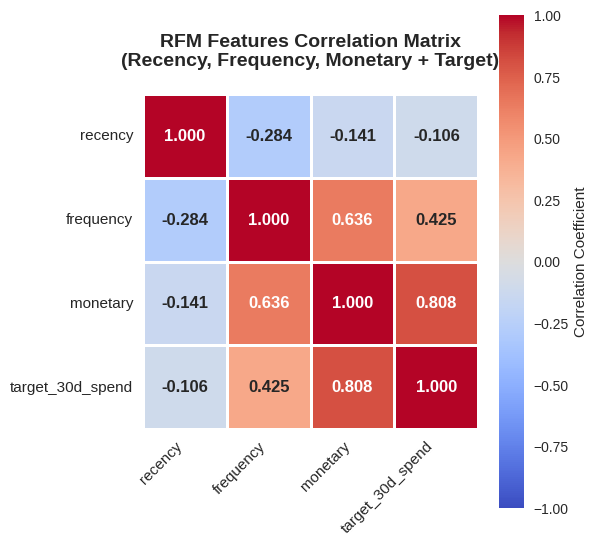


CORRELATION WITH TARGET (30-day Future Spend):
monetary       :   0.808  |  ↑ Increases     (Strong)
frequency      :   0.425  |  ↑ Increases     (Moderate)
recency        :  -0.106  |  ↓ Decreases     (Weak)


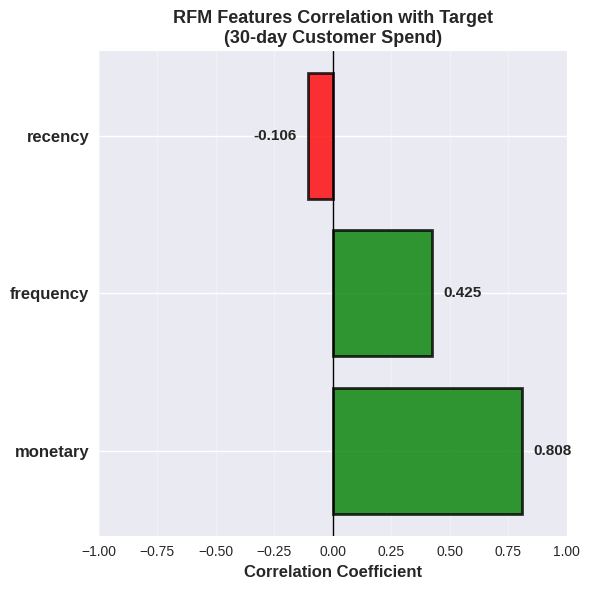


RFM FEATURE INTERCORRELATIONS:

Recency ↔ Frequency: -0.284
Recency ↔ Monetary:  -0.141
Frequency ↔ Monetary: 0.636

KEY INSIGHTS:

✓ Strongest RFM predictor: MONETARY
  Correlation: 0.808

✗ Weakest RFM predictor: RECENCY
  Correlation: -0.106

INTERPRETATION:

• MONETARY (Strong positive correlation: 0.808)
  Customers who spent more historically tend to spend more in the future.

• FREQUENCY (Correlation: 0.425)
  Customers with more transactions tend to {'spend more' if target_rfm_corr['frequency'] > 0 else 'spend less'} in the future.

• RECENCY (Negative correlation: -0.106)
  Customers who purchased recently tend to spend more in the future.


In [ ]:
# =========================
# 6.7. RFM CORRELATION MATRIX
# =========================
print("=" * 70)
print("RFM FEATURES CORRELATION ANALYSIS")
print("=" * 70)

# Merge RFM data with target
rfm_with_target = rfm_data.copy()
rfm_with_target = rfm_with_target.merge(future_spend, on="CustomerID", how="left")
rfm_with_target["target_30d_spend"] = rfm_with_target["target_30d_spend"].fillna(0)

# Select only RFM + target columns
rfm_features = ["recency", "frequency", "monetary", "target_30d_spend"]
rfm_corr_data = rfm_with_target[rfm_features]

# Calculate correlation matrix
rfm_corr_matrix = rfm_corr_data.corr()

print("\nRFM CORRELATION MATRIX:")
print(rfm_corr_matrix)

# Create heatmap for RFM features
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(rfm_corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", center=0,
            cbar_kws={"label": "Correlation Coefficient"}, vmin=-1, vmax=1,
            square=True, linewidths=2, ax=ax, annot_kws={"size": 12, "weight": "bold"})
ax.set_title("RFM Features Correlation Matrix\n(Recency, Frequency, Monetary + Target)",
             fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

# Extract correlations with target
target_rfm_corr = rfm_corr_matrix["target_30d_spend"].drop("target_30d_spend").sort_values(ascending=False)

print("\n" + "=" * 70)
print("CORRELATION WITH TARGET (30-day Future Spend):")
print("=" * 70)
for feature, corr_val in target_rfm_corr.items():
    strength = "Strong" if abs(corr_val) > 0.5 else "Moderate" if abs(corr_val) > 0.3 else "Weak"
    direction = "↑ Increases" if corr_val > 0 else "↓ Decreases"
    print(f"{feature:15s}: {corr_val:7.3f}  |  {direction:15s} ({strength})")

# Create bar chart for RFM vs Target
fig, ax = plt.subplots(figsize=(6, 6))
colors = ['green' if x > 0 else 'red' for x in target_rfm_corr.values]
bars = ax.barh(range(len(target_rfm_corr)), target_rfm_corr.values, color=colors,
               edgecolor='black', alpha=0.8, linewidth=2)
ax.set_yticks(range(len(target_rfm_corr)))
ax.set_yticklabels(target_rfm_corr.index, fontsize=12, fontweight="bold")
ax.set_xlabel("Correlation Coefficient", fontsize=12, fontweight="bold")
ax.set_title("RFM Features Correlation with Target\n(30-day Customer Spend)",
             fontsize=13, fontweight="bold")
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(-1, 1)

# Add value labels
for i, v in enumerate(target_rfm_corr.values):
    ax.text(v + 0.05 if v > 0 else v - 0.05, i, f'{v:.3f}',
            va='center', ha='left' if v > 0 else 'right', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# RFM Intercorrelations
print("\n" + "=" * 70)
print("RFM FEATURE INTERCORRELATIONS:")
print("=" * 70)
print(f"\nRecency ↔ Frequency: {rfm_corr_matrix.loc['recency', 'frequency']:.3f}")
print(f"Recency ↔ Monetary:  {rfm_corr_matrix.loc['recency', 'monetary']:.3f}")
print(f"Frequency ↔ Monetary: {rfm_corr_matrix.loc['frequency', 'monetary']:.3f}")

print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
strongest = target_rfm_corr.idxmax()
weakest = target_rfm_corr.idxmin()
print(f"\n✓ Strongest RFM predictor: {strongest.upper()}")
print(f"  Correlation: {target_rfm_corr[strongest]:.3f}")
print(f"\n✗ Weakest RFM predictor: {weakest.upper()}")
print(f"  Correlation: {target_rfm_corr[weakest]:.3f}")

# Interpretation
print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
if target_rfm_corr["monetary"] > 0:
    print(f"\n• MONETARY (Strong positive correlation: {target_rfm_corr['monetary']:.3f})")
    print("  Customers who spent more historically tend to spend more in the future.")

if target_rfm_corr["frequency"] > 0:
    print(f"\n• FREQUENCY (Correlation: {target_rfm_corr['frequency']:.3f})")
    print("  Customers with more transactions tend to {'spend more' if target_rfm_corr['frequency'] > 0 else 'spend less'} in the future.")

if target_rfm_corr["recency"] < 0:
    print(f"\n• RECENCY (Negative correlation: {target_rfm_corr['recency']:.3f})")
    print("  Customers who purchased recently tend to spend more in the future.")
elif target_rfm_corr["recency"] > 0:
    print(f"\n• RECENCY (Positive correlation: {target_rfm_corr['recency']:.3f})")
    print("  Customers who purchased longer ago still tend to spend more.")


In [ ]:
# =========================
# 9. REGRESSION MODELS
# =========================
models = {
    "Linear Regression": LinearRegression(),

    "Support Vector Regression": SVR(
        kernel="rbf",
        C=10,
        epsilon=0.1
    ),

    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ),

    "XGBoost Regressor": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
}

In [ ]:
# =========================
# 10. TRAIN & EVALUATE
# =========================
results = []

for name, model in models.items():

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X, y)
    preds = pipeline.predict(X)

    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds)) # Corrected RMSE calculation
    r2 = r2_score(y, preds)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

    print(f"\n{name}")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R2  :", r2)


Linear Regression
MAE : 193.01975779705802
RMSE: 655.7618545299871
R2  : 0.6874169129338867

Support Vector Regression
MAE : 163.03782662988368
RMSE: 1177.393404298793
R2  : -0.007665460336653052

Random Forest Regressor
MAE : 130.06444411041775
RMSE: 358.65229373396056
R2  : 0.906498107598385

XGBoost Regressor
MAE : 88.55941446343637
RMSE: 153.57675001124937
R2  : 0.9828555277490568


In [ ]:
# =========================
# 11. FINAL COMPARISON
# =========================
results_df = pd.DataFrame(results).sort_values("MAE")
print("\nFINAL MODEL COMPARISON")
print(results_df)



FINAL MODEL COMPARISON
                       Model         MAE         RMSE        R2
3          XGBoost Regressor   88.559414   153.576750  0.982856
2    Random Forest Regressor  130.064444   358.652294  0.906498
1  Support Vector Regression  163.037827  1177.393404 -0.007665
0          Linear Regression  193.019758   655.761855  0.687417


In [ ]:
# ============================================================
# SHORT-TERM CUSTOMER LIFETIME VALUE (CLV) PREDICTION
# TRAIN : Before 01-10-2011
# TEST  : 01-10-2011 to 31-10-2011
# MODELS: LR | SVR | RF | XGBoost
# DATA  : UCI Online Retail II (KaggleHub)
# ============================================================

# =========================
# 1. IMPORTS
# =========================
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

plt.style.use("seaborn-v0_8")


# =========================
# 2. DATA LOADING (KAGGLEHUB)
# =========================
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

files = []
for root, _, filenames in os.walk(path):
    for f in filenames:
        if f.endswith(".csv"):
            files.append(os.path.join(root, f))

df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# Standardize column names
df.columns = df.columns.str.strip().str.replace(" ", "")
df.rename(columns={"Invoice": "InvoiceNo", "Price": "UnitPrice"}, inplace=True)

print("Initial shape:", df.shape)


# =========================
# 3. DATA CLEANING
# =========================
# Drop rows without CustomerID (mandatory for CLV)
df = df.dropna(subset=["CustomerID"])

# Datetime conversion
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

# Remove cancelled invoices
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Keep only valid transactions
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Transaction value
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

print("After cleaning:", df.shape)


# =========================
# 4. DATE DEFINITIONS (STRICT)
# =========================
TRAIN_END_DATE = datetime(2011, 10, 1)
TEST_START_DATE = datetime(2011, 10, 1)
TEST_END_DATE = datetime(2011, 10, 31)

train_txn = df[df["InvoiceDate"] < TRAIN_END_DATE]
test_txn  = df[(df["InvoiceDate"] >= TEST_START_DATE) &
               (df["InvoiceDate"] <= TEST_END_DATE)]


# =========================
# 5. TARGET (TEST WINDOW SPEND)
# =========================
future_spend = (
    test_txn.groupby("CustomerID")["TotalPrice"]
    .sum()
    .reset_index(name="target_30d_spend")
)


# =========================
# 6. FEATURE ENGINEERING (TRAIN ONLY)
# =========================
features = train_txn.groupby("CustomerID").agg(
    recency=("InvoiceDate", lambda x: (TRAIN_END_DATE - x.max()).days),
    frequency=("InvoiceNo", "nunique"),
    total_quantity=("Quantity", "sum"),
    total_spend=("TotalPrice", "sum"),
    avg_order_value=("TotalPrice", "mean"),
    unique_products=("StockCode", "nunique"),
    country=("Country", "first")
).reset_index()

data = features.merge(future_spend, on="CustomerID", how="left")
data["target_30d_spend"] = data["target_30d_spend"].fillna(0)


# =========================
# 7. BASELINE (NAIVE MEAN)
# =========================
baseline_pred = np.full(len(data), data["target_30d_spend"].mean())
print("Baseline MAE:",
      mean_absolute_error(data["target_30d_spend"], baseline_pred))


# =========================
# 8. FINAL DATASET
# =========================
X = data.drop(columns=["CustomerID", "target_30d_spend"])
y = data["target_30d_spend"]

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = ["country"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


# =========================
# 9. REGRESSION MODELS
# =========================
models = {
    "Linear Regression": LinearRegression(),

    "Support Vector Regression": SVR(
        kernel="rbf",
        C=10,
        epsilon=0.1
    ),

    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ),

    "XGBoost Regressor": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
}


# =========================
# 10. TRAIN & EVALUATE
# =========================
results = []

for name, model in models.items():

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X, y)
    preds = pipeline.predict(X)

    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds)) # Corrected RMSE calculation
    r2 = r2_score(y, preds)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

    print(f"\n{name}")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R2  :", r2)


# =========================
# 11. FINAL COMPARISON
# =========================
results_df = pd.DataFrame(results).sort_values("MAE")
print("\nFINAL MODEL COMPARISON")
print(results_df)


Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.
Initial shape: (1067371, 8)
After cleaning: (805549, 9)
Baseline MAE: 266.22978784819776

Linear Regression
MAE : 193.01975779705802
RMSE: 655.7618545299871
R2  : 0.6874169129338867

Support Vector Regression
MAE : 163.03782662988368
RMSE: 1177.393404298793
R2  : -0.007665460336653052

Random Forest Regressor
MAE : 130.06444411041775
RMSE: 358.65229373396056
R2  : 0.906498107598385

XGBoost Regressor
MAE : 88.55941446343637
RMSE: 153.57675001124937
R2  : 0.9828555277490568

FINAL MODEL COMPARISON
                       Model         MAE         RMSE        R2
3          XGBoost Regressor   88.559414   153.576750  0.982856
2    Random Forest Regressor  130.064444   358.652294  0.906498
1  Support Vector Regression  163.037827  1177.393404 -0.007665
0          Linear Regression  193.019758   655.761855  0.687417


In [ ]:
df.to_csv("Clv_task.csv")